In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations
from IPython.display import display
from notebook import plot_NQueens

# Problems

#### This is the abstract class. Specific problem domains will subclass this.

In [2]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        
        raise NotImplementedError
    def result(self, state, action): 
        raise NotImplementedError
    def is_goal(self, state):        
        return state == self.goal
    def action_cost(self, s, a, s1): 
        return 1
    
    def __str__(self):
        return '{0}({1}, {2})'.format(
            type(self).__name__, self.initial, self.goal)

# Nodes

#### This is the Node in the search tree. Helper functions (expand, path_actions, path_states) use this Node class.

In [3]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __str__(self): 
        return '<{0}>'.format(self.state)
    def __len__(self): 
        return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): 
        return self.path_cost < other.path_cost

In [4]:
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

# Helper functions

In [5]:
def expand(problem, state):
    return problem.actions(state)

# Solving NQueens Problem using Hill Climbing

In [6]:
class NQueensProblem(Problem):

    def __init__(self, N):
        super().__init__(initial=tuple(random.randint(0,N-1) for _ in tuple(range(N))))
        self.N = N

    def actions(self, state):
        """ finds the nearest neighbors"""
        neighbors = []
        for i in range(self.N):
            for j in range(self.N):
                if j == state[i]:
                    continue
                s1 = list(state)
                s1[i]=j
                new_state = tuple(s1)
                yield Node(state=new_state)

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):
        """Return number of conflicting queens for a given node"""
        num_conflicts = 0
        for (r1,c1) in enumerate(node.state):
            for(r2,c2) in enumerate(node.state):
                if(r1,c1)!=(r2,c2):
                    num_conflicts+=self.conflict(r1,c1,r2,c2)
        return num_conflicts

In [7]:
def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items

In [8]:
def argmin_random_tie(seq, key):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return min(shuffled(seq), key=key)

In [9]:
def hill_climbing(problem,iterations = 10000):
    # as this is a stochastic algorithm, we will set a cap on the number of iterations        
    current = Node(problem.initial)
    i=1
    while i < iterations:
        neighbors = expand(problem,current.state)
        if not neighbors:
            break
        neighbor=argmin_random_tie(neighbors,key=lambda node:problem.h(node))
        if problem.h(neighbor)<=problem.h(current):
            current.state=neighbor.state
            if problem.goal_test(current.state)==True:
                print("Goal test succeeded at iteration {0}".format(i))
                return current
        i += 1        
    return current    

In [10]:
nq1=NQueensProblem(8)

C:\Users\Y Chethan\notebook.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


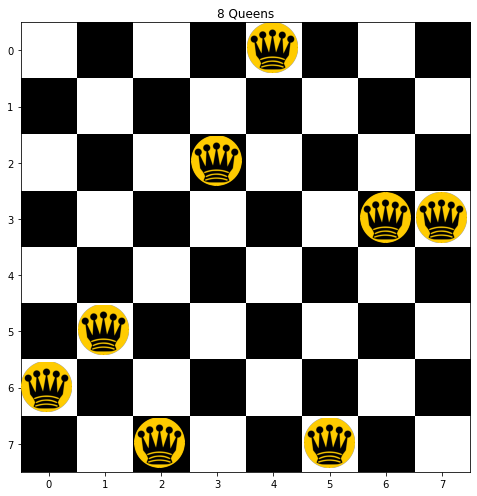

In [11]:
plot_NQueens(nq1.initial)

In [12]:
n1 = Node(state=nq1.initial)

In [13]:
num_conflicts = nq1.h(n1)

In [14]:
print("Initial Conflicts = {0}".format(num_conflicts))

Initial Conflicts = 10


In [15]:
sol1=hill_climbing(nq1,iterations=20000)

Goal test succeeded at iteration 4


In [16]:
sol1.state

(3, 5, 7, 2, 0, 6, 4, 1)

In [17]:
num_conflicts = nq1.h(sol1)

In [18]:
print("Final Conflicts = {0}".format(num_conflicts))

Final Conflicts = 0


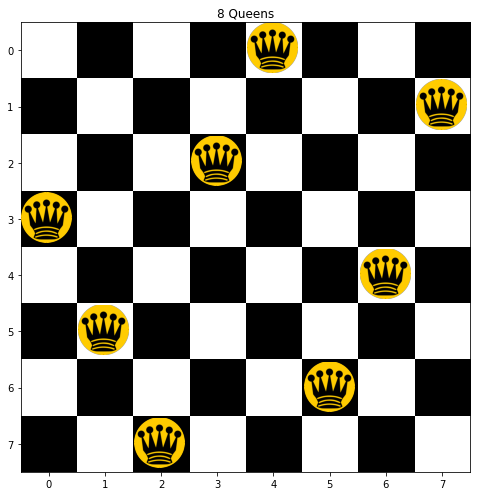

In [19]:
plot_NQueens(list(sol1.state))

N-value 8
Goal test succeeded at iteration 7
N-value 16
Goal test succeeded at iteration 34
N-value 32
Goal test succeeded at iteration 45
N-value 64
Goal test succeeded at iteration 47


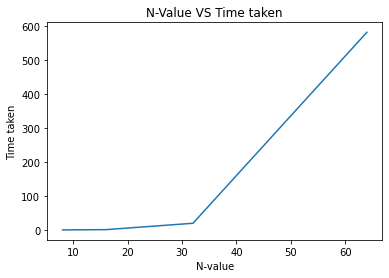

In [20]:
import time
n_values=[2**x for x in range(3,7)]
time_taken=[]
num=1
for each_i in n_values:
    nq1=NQueensProblem(each_i)
    n1 = Node(state=nq1.initial)
    num_conflicts = nq1.h(n1)
    print("N-value {0}".format(each_i))
    start=time.time()
    sol1=hill_climbing(nq1,iterations=100)
    end=time.time()
    num_conflicts = nq1.h(sol1)
    time_taken.append(end-start)
    num+=1
plt.title("N-Value VS Time taken")
plt.xlabel("N-value")
plt.ylabel("Time taken")
plt.plot(n_values,time_taken)
plt.show()